### SHIP

In [14]:
import copy
import random
from PIL import Image, ImageDraw

class Ship:
    def __init__(self, D, flammability, bot_class):
        self.D = D  # Grid size
        self.q = flammability  # Fire spread probability
        self.ship = [['#' for _ in range(D)] for _ in range(D)]  # Initialize with walls
        self.open_cells = []
        self.fire_cells = []
        self.bot = None
        self.goal_position = None

        self.generate_ship_layout()
        self.initialize_fire()
        self.initialize_goal()
        self.initialize_bot(bot_class)

    def neighbors(self, row, col):
        """Returns valid neighboring cells (Up, Down, Left, Right)"""
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return [(row + r, col + c) for r, c in directions if 0 <= row + r < self.D and 0 <= col + c < self.D]

    def generate_ship_layout(self):
        """Generates the open path layout of the ship"""
        for i in range(self.D):
            self.ship[0][i] = '#'  # Top border
            self.ship[self.D - 1][i] = '#'  # Bottom border
            self.ship[i][0] = '#'  # Left border
            self.ship[i][self.D - 1] = '#'  # Right border

        # Generating the open cells within the inner grid
        initial_row, initial_col = random.randint(1, self.D - 2), random.randint(1, self.D - 2)
        self.ship[initial_row][initial_col] = 'O'
        self.open_cells.append((initial_row, initial_col))

        # Make sure that no open cells are placed on the border
        while True:
            candidates = [(r, c) for r in range(1, self.D - 1) for c in range(1, self.D - 1)
                        if self.ship[r][c] == '#' and 
                        sum(self.ship[nr][nc] == 'O' for nr, nc in self.neighbors(r, c)) == 1]
            
            if not candidates:
                break
            
            row, col = random.choice(candidates)

            # Ensure it doesn't open a path to the border
            if row in [0, self.D - 1] or col in [0, self.D - 1]: 
                continue  # Skip border cells

            self.ship[row][col] = 'O'
            self.open_cells.append((row, col))

        # Reduce dead ends inside the grid
        dead_ends = [(r, c) for r, c in self.open_cells 
                    if sum(self.ship[nr][nc] == 'O' for nr, nc in self.neighbors(r, c)) == 1]

        random.shuffle(dead_ends)
        for row, col in dead_ends[:len(dead_ends) // 2]:
            closed_neighbors = [(nr, nc) for nr, nc in self.neighbors(row, col) if self.ship[nr][nc] == '#']
            
            if closed_neighbors:
                nr, nc = random.choice(closed_neighbors)

                # Ensure new open cell isn't on the border
                if nr in [0, self.D - 1] or nc in [0, self.D - 1]: 
                    continue

                self.ship[nr][nc] = 'O'
                self.open_cells.append((nr, nc))


    def initialize_goal(self):
        """Places the goal ('G') in an open position, avoiding fire"""
        row, col = random.choice([pos for pos in self.open_cells if pos not in self.fire_cells])
        self.ship[row][col] = 'G'
        self.goal_position = (row, col)

    def initialize_bot(self, bot_class):
        """Places the bot ('B') in an open position, avoiding fire and the goal"""
        row, col = random.choice([pos for pos in self.open_cells if pos not in self.fire_cells and pos != self.goal_position])
        self.ship[row][col] = 'B'
        self.bot = bot_class((row, col), self.goal_position, self)

    def initialize_fire(self):
        """Places the initial fire cell ('F') in a single open position and starts spreading."""
        # Start fire from a random open cell
        row, col = random.choice(self.open_cells)
        self.ship[row][col] = 'F'
        self.fire_cells.append((row, col))
        print(f"Fire started at position: ({row}, {col})")

    def spread_fire(self):
        """Spreads fire ('F') to neighboring open cells ('O') based on probability."""
        new_fire_cells = []
        for row, col in self.fire_cells:  # Only spread fire from burning cells
            for nr, nc in self.neighbors(row, col):
                if self.ship[nr][nc] == 'O':  # Only spread to open cells
                    K = sum(self.ship[nr2][nc2] == 'F' for nr2, nc2 in self.neighbors(nr, nc))
                    if random.random() < 1 - (1 - self.q) ** K:
                        if (nr, nc) == self.goal_position:
                            print("The goal is on fire! Mission failed.")
                            return "goal on fire"
                        if (nr, nc) == self.bot.position:
                            print("The bot is on fire! Mission failed.")
                            return "Bot on fire"
                        self.ship[nr][nc] = 'F'
                        new_fire_cells.append((nr, nc))
        self.fire_cells.extend(new_fire_cells)
        return None  



    def display_grid(self):
        """Prints the current ship grid"""
        for row in self.ship:
            print(' '.join(row))
        print()

    def snapshot_environment(self):
        """Saves the current environment for testing"""
        return {
            'ship': copy.deepcopy(self.ship),
            'open_cells': self.open_cells[:],
            'fire_cells': self.fire_cells[:],
            'goal_position': self.goal_position,
            'start_position': self.bot.position,
        }

    def load_snapshot(self, snapshot):
        """Restores a saved environment state"""
        self.ship = copy.deepcopy(snapshot['ship'])
        self.open_cells = snapshot['open_cells'][:]
        self.fire_cells = snapshot['fire_cells'][:]
        self.goal_position = snapshot['goal_position']
        self.bot.position = snapshot['start_position']

    def mark_path(self, path):
        """Marks a given path with '*'"""
        for row, col in path:
            if self.ship[row][col] == 'O':
                self.ship[row][col] = '*'



### BOT 1

In [15]:
import heapq
from collections import deque

class Bot1:
    def __init__(self, start_position, goal_position, ship):
        self.position = start_position
        self.goal_position = goal_position
        self.ship = ship
        self.fire_started = True  # Track when fire starts

    def bfs_find_path(self):
        queue = deque([(self.position, [])])
        visited = set()
        
        while queue:
            current, path = queue.popleft()
            if current in visited:
                continue
            visited.add(current)
            
            if current == self.goal_position:
                return path + [current]
            
            for neighbor in self.ship.neighbors(*current):
                if self.ship.ship[neighbor[0]][neighbor[1]] in ('O', 'G'):
                    queue.append((neighbor, path + [current]))
        
        return None
    
    def move(self):
        time_step = 0
        traversed_path = []
        path = self.bfs_find_path()

        if not path:
            print("No initial path to the goal! The bot is trapped.")
            return False, time_step, "No path to the goal available"

        for next_step in path[1:]:
            row, col = next_step

            if self.ship.ship[row][col] == 'F':
                print("Bot caught on fire! Mission failed.")
                return False, time_step, "Bot got caught in fire"

            traversed_path.append(self.position)
            self.ship.ship[self.position[0]][self.position[1]] = '*'  # Mark path
            self.ship.ship[row][col] = 'B'  # Move bot
            self.position = (row, col)

            time_step += 1
            print(f"\n--- Time Step {time_step} ---")
            print(f"Bot moved to {self.position}")
            self.ship.display_grid()

            if self.position == self.goal_position:
                print("The bot reached the goal and saved the day!")
                for cell in traversed_path:
                    if self.ship.ship[cell[0]][cell[1]] == 'O':
                        self.ship.ship[cell[0]][cell[1]] = '*'
                return True, time_step, "Success"

            if not self.fire_started:
                self.fire_started = any('F' in row for row in self.ship.ship)
            
            self.ship.spread_fire()

            if self.ship.ship[self.goal_position[0]][self.goal_position[1]] == 'F':
                print("The goal is on fire! The mission failed.")
                return False, time_step, "Goal got caught on fire"

        print("No path to the goal! The bot is trapped.")
        return False, time_step, "Bot got trapped due to fire spread"

### BOT 2

In [16]:
import heapq


class Bot2:
    def __init__(self, start_position, goal_position, ship):
        self.position = start_position
        self.goal_position = goal_position
        self.ship = ship

    def heuristic(self, cell):
        return abs(cell[0] - self.goal_position[0]) + abs(cell[1] - self.goal_position[1])

    def find_path(self, method='a_star'):
        if method == 'bfs':
            return self.bfs()
        elif method == 'a_star':
            return self.a_star()

    def bfs(self):
        queue = deque([self.position])
        came_from = {self.position: None}

        while queue:
            current = queue.popleft()
            if current == self.goal_position:
                return self.reconstruct_path(came_from, current)

            for neighbor in self.ship.neighbors(*current):
                if neighbor not in came_from and self.ship.ship[neighbor[0]][neighbor[1]] in ('O', 'G') and self.ship.ship[neighbor[0]][neighbor[1]] != 'F':
                    queue.append(neighbor)
                    came_from[neighbor] = current

        return None

    def a_star(self):
        open_list = []
        heapq.heappush(open_list, (0, self.position))
        came_from = {self.position: None}
        g_score = {self.position: 0}
        f_score = {self.position: self.heuristic(self.position)}

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == self.goal_position:
                return self.reconstruct_path(came_from, current)

            for neighbor in self.ship.neighbors(*current):
                if neighbor not in came_from and self.ship.ship[neighbor[0]][neighbor[1]] in ('O', 'G', '*') and self.ship.ship[neighbor[0]][neighbor[1]] != 'F':
                    tentative_g_score = g_score[current] + 1
                    if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + self.heuristic(neighbor)
                        heapq.heappush(open_list, (f_score[neighbor], neighbor))

        return None


    def move(self):
        time_step = 0
        traversed_path = []  # List to store all traversed cells

        # Plan the initial path to the goal, ignoring fire spread
        path = self.find_path('a_star')

        if not path:
            print("No initial path to the goal! The bot is trapped.")
            return False, time_step, "No path to the goal available"

        # Follow the planned path until the goal is reached or fire blocks the path
        for next_step in path[1:]:
            row, col = next_step

            # If fire has spread to the next cell in the planned path, terminate
            if self.ship.ship[row][col] == 'F':
                print("Encountered fire along the path! The bot is trapped.")
                return False, time_step, "Bot got caught in fire along path"

            # Move to the next cell
            traversed_path.append(self.position)
            self.ship.ship[self.position[0]][self.position[1]] = '*'  # Mark path cell
            self.ship.ship[row][col] = 'B'  # Mark bot's new position
            self.position = (row, col)

            time_step += 1  # Increment the time step
            print(f"\n--- Time Step {time_step} ---")
            print(f"Bot moved to {self.position}")
            self.ship.display_grid()

            # Check if the bot has reached the goal
            if self.position == self.goal_position:
                print("The bot reached the goal and saved the day!")
                # Mark the entire path
                for cell in traversed_path:
                    if self.ship.ship[cell[0]][cell[1]] == 'O':  # Only mark open cells
                        self.ship.ship[cell[0]][cell[1]] = '*'
                return True, time_step, "Success"

            # Spread fire and check if the goal is now on fire
            self.ship.spread_fire()
            if self.ship.ship[self.goal_position[0]][self.goal_position[1]] == 'F':
                print("The goal is on fire! The mission failed.")
                return False, time_step, "goal got caught on fire"

        # If the bot completes the loop without reaching the goal, it is trapped
        print("No path to the goal! The bot is trapped.")
        return False, time_step, "Bot got trapped due to fire spread"

    def reconstruct_path(self, came_from, current):
        # Trace back the path from the goal (or current) node to the start node
        path = []
        while current is not None:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path


### BOT 3

In [17]:
import heapq

class Bot3:
    def __init__(self, start_position, goal_position, ship):
        self.position = start_position
        self.goal_position = goal_position
        self.ship = ship

    def heuristic(self, cell):
        return abs(cell[0] - self.goal_position[0]) + abs(cell[1] - self.goal_position[1])

    def find_path(self, method='a_star', avoid_adjacent_fire=True):
        if method == 'bfs':
            return self.bfs(avoid_adjacent_fire)
        elif method == 'a_star':
            return self.a_star(avoid_adjacent_fire)

    def bfs(self, avoid_adjacent_fire):
        queue = deque([self.position])
        came_from = {self.position: None}

        while queue:
            current = queue.popleft()
            if current == self.goal_position:
                return self.reconstruct_path(came_from, current)

            for neighbor in self.ship.neighbors(*current):
                if neighbor not in came_from and self.is_safe(neighbor, avoid_adjacent_fire):
                    queue.append(neighbor)
                    came_from[neighbor] = current

        return None

    def a_star(self, avoid_adjacent_fire):
        open_list = []
        heapq.heappush(open_list, (0, self.position))
        came_from = {self.position: None}
        g_score = {self.position: 0}
        f_score = {self.position: self.heuristic(self.position)}

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == self.goal_position:
                return self.reconstruct_path(came_from, current)

            for neighbor in self.ship.neighbors(*current):
                if self.is_safe(neighbor, avoid_adjacent_fire):
                    tentative_g_score = g_score[current] + 1
                    if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + self.heuristic(neighbor)
                        heapq.heappush(open_list, (f_score[neighbor], neighbor))

        return None

    def is_safe(self, cell, avoid_adjacent_fire):
        row, col = cell

        if self.ship.ship[row][col] not in ('O', 'G', '*') or self.ship.ship[row][col] == 'F':
            return False

        if avoid_adjacent_fire:
            for r, c in self.ship.neighbors(row, col):
                if self.ship.ship[r][c] == 'F':
                    return False

        return True

    def move(self):
        time_step = 0
        traversed_path = []  # List to store all traversed cells

        # Plan the initial path to the goal, ignoring fire spread
        path = self.find_path('a_star')

        if not path:
            print("No initial path to the goal! The bot is trapped.")
            return False, time_step, "No path to the goal available"

        # Follow the planned path until the goal is reached or fire blocks the path
        for next_step in path[1:]:
            row, col = next_step

            # If fire has spread to the next cell in the planned path, terminate
            if self.ship.ship[row][col] == 'F':
                print("Encountered fire along the path! The bot is trapped.")
                return False, time_step, "Bot got caught in fire along path"

            # Move to the next cell
            traversed_path.append(self.position)
            self.ship.ship[self.position[0]][self.position[1]] = '*'  # Mark path cell
            self.ship.ship[row][col] = 'B'  # Mark bot's new position
            self.position = (row, col)

            time_step += 1  # Increment the time step
            print(f"\n--- Time Step {time_step} ---")
            print(f"Bot moved to {self.position}")
            self.ship.display_grid()

            # Check if the bot has reached the goal
            if self.position == self.goal_position:
                print("The bot reached the goal and saved the day!")
                # Mark the entire path
                for cell in traversed_path:
                    if self.ship.ship[cell[0]][cell[1]] == 'O':  # Only mark open cells
                        self.ship.ship[cell[0]][cell[1]] = '*'
                return True, time_step, "Success"

            # Spread fire and check if the goal is now on fire
            self.ship.spread_fire()
            if self.ship.ship[self.goal_position[0]][self.goal_position[1]] == 'F':
                print("The goal is on fire! The mission failed.")
                return False, time_step, "goal got caught on fire"

        # If the bot completes the loop without reaching the goal, it is trapped
        print("No path to the goal! The bot is trapped.")
        return False, time_step, "Bot got trapped due to fire spread"



    def reconstruct_path(self, came_from, current):
        # Trace back the path from the goal (or current) node to the start node
        path = []
        while current is not None:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path



### BOT 4

In [18]:
import heapq

class Bot4:
    def __init__(self, start_position, goal_position, ship):
        self.position = start_position
        self.goal_position = goal_position
        self.ship = ship
        self.risk_tolerance = 0.2  # Base risk tolerance for path selection

    def heuristic(self, cell):
        # Heuristic with fire risk calculation
        distance_to_goal = abs(cell[0] - self.goal_position[0]) + abs(cell[1] - self.goal_position[1])
        fire_risk = self.calculate_fire_risk(cell)
        return distance_to_goal + (fire_risk * self.risk_tolerance)

    def calculate_fire_risk(self, cell, max_radius=3):
        # Fire risk function with decaying risk based on distance
        risk_decay = {1: 1.0, 2: 0.8, 3: 0.6}
        fire_count = 0

        for r in range(cell[0] - max_radius, cell[0] + max_radius + 1):
            for c in range(cell[1] - max_radius, cell[1] + max_radius + 1):
                # Check if the cell is within bounds of the grid
                if 0 <= r < self.ship.D and 0 <= c < self.ship.D:
                    if (r, c) != cell:
                        distance = abs(r - cell[0]) + abs(c - cell[1])  
                        if distance <= max_radius and self.ship.ship[r][c] == 'F':
                            fire_count += risk_decay.get(distance, 0)  

        return fire_count

    def multi_step_lookahead(self, cell, depth=3):
        if depth == 0 or self.ship.ship[cell[0]][cell[1]] == 'F':
            return 0

        survivability = 1
        for future_cell in self.ship.neighbors(*cell):
            # Allow traversal to open ('O'), goal ('G'), or previously visited ('*') cells
            if self.ship.ship[future_cell[0]][future_cell[1]] in ('O', 'G', '*'):
                future_fire_risk = self.calculate_fire_risk(future_cell)
                if future_fire_risk < self.risk_tolerance:
                    survivability += self.multi_step_lookahead(future_cell, depth - 1)

        return survivability

    def a_star_resilient(self):
        open_list = []
        heapq.heappush(open_list, (0, self.position))
        came_from = {self.position: None}
        g_score = {self.position: 0}
        f_score = {self.position: self.heuristic(self.position)}

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == self.goal_position:
                return self.reconstruct_path(came_from, current)

            for neighbor in self.ship.neighbors(*current):
                # Allow traversing cells that are open ('O'), the goal ('G'), or previously visited ('*')
                if self.ship.ship[neighbor[0]][neighbor[1]] in ('O', 'G', '*') and self.ship.ship[neighbor[0]][neighbor[1]] != 'F':
                    tentative_g_score = g_score[current] + 1
                    lookahead_survivability = self.multi_step_lookahead(neighbor)
                    if lookahead_survivability > self.risk_tolerance:
                        if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                            came_from[neighbor] = current
                            g_score[neighbor] = tentative_g_score
                            f_score[neighbor] = tentative_g_score + self.heuristic(neighbor)
                            heapq.heappush(open_list, (f_score[neighbor], neighbor))

        return None

    def move(self):
        time_step = 0
        traversed_path = [] 

        while True:
            path = self.a_star_resilient()
            if not path:
                print("No safe path to the goal! The bot is trapped.")
                self.ship.mark_path(traversed_path)
                return False, time_step, "No path to the goal available"

            next_step = path[1]  # Get the next step
            row, col = next_step

            # Mark the cell the bot is leaving as '*'
            traversed_path.append(self.position)
            self.ship.ship[self.position[0]][self.position[1]] = '*'  # Mark old position as revisitable
            self.ship.ship[row][col] = 'B'  # Mark new position with bot
            self.position = (row, col)

            time_step += 1
            print(f"Bot moved to {self.position} at step {time_step}")
            self.ship.display_grid()

            # Check if the bot has reached the goal
            if self.position == self.goal_position:
                print("The bot reached the goal and saved the day!")
                self.ship.mark_path(traversed_path)
                return True, time_step, "Success"

            # Spread fire and check if the goal is now on fire
            self.ship.spread_fire()
            if self.ship.ship[self.goal_position[0]][self.goal_position[1]] == 'F':
                print("The goal is on fire! The mission failed.")
                self.ship.mark_path(traversed_path)
                return False, time_step, "goal got caught on fire"

            # Check if the bot's current cell has caught fire
            if self.ship.ship[row][col] == 'F':
                print("The bot got caught in the fire!")
                self.ship.mark_path(traversed_path)
                return False, time_step, "Bot got caught in fire"


    def reconstruct_path(self, came_from, current):
        path = []
        while current is not None:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

### Graph and Bots Simulation

In [19]:
import numpy as np
import pandas as pd
import os
import random
import ast
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

def output_combined_image(ships, bots, filename, show_solution=True, show_explored=False, show_fire=True):
    cell_size = 50
    cell_border = 2
    num_bots = len(bots)

    colors = [(127, 0, 255),  # Bot 1
              (255, 0, 255),  # Bot 2
              (0,0,255),      # Bot 3
              (0,255,255)]    # Bot 4  

    fig, axes = plt.subplots(1, num_bots, figsize=(num_bots * 5, 5))
    if num_bots == 1:
        axes = [axes]

    for ax, bot, ship, color in zip(axes, bots, ships, colors[:num_bots]):
        bot_class_name = bot.__class__.__name__
        img = Image.new("RGBA", (ship.D * cell_size, ship.D * cell_size), "black")
        draw = ImageDraw.Draw(img)

        solution = getattr(ship, 'solution', None)
        start_position = bot.position

        for i, row in enumerate(ship.ship):
            for j, col in enumerate(row):
                if col == '#':
                    fill = (40, 40, 40)  
                elif (i, j) == start_position:
                    fill = color  
                elif (i, j) == bot.position:
                    fill = (173, 216, 230)  
                elif (i, j) == ship.goal_position:
                    fill = (0, 171, 28)  
                elif show_fire and ship.ship[i][j] == 'F':
                    fill = (255, 0, 0)  
                elif col == '*':
                    fill = (255, 223, 0)  
                elif solution is not None and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)  
                elif show_explored and solution is not None and (i, j) in ship.explored:
                    fill = (48, 10, 10)  
                else:
                    fill = (237, 240, 252)  

                draw.ellipse(
                    [(j * cell_size + cell_border, i * cell_size + cell_border),
                     ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)],
                    fill=fill
                )

        ax.imshow(img)
        ax.set_title(f"{bot_class_name}")
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return filename

def run_simulation_for_bots(bot_classes, num_simulations, D=40, output_csv="Bot Results.csv", failure_csv="Bot Failure Reasons.csv"):
    all_results = []
    failure_reasons = []
    bot_success_counts = {bot_class.__name__: 0 for bot_class in bot_classes} 
    q_values_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # q values for simulation
    
    # Loop through each q value
    for q in q_values_list: 
        for sim in range(num_simulations):
            print(f"Running simulation {sim+1} with q={q:.2f}")  

            base_ship = Ship(D, flammability=q, bot_class=bot_classes[0])
            initial_snapshot = base_ship.snapshot_environment()

            bots = []
            ships = []

            for bot_class in bot_classes:
                ship = Ship(D, flammability=q, bot_class=bot_class)
                ship.load_snapshot(initial_snapshot)
                bot_start_position = initial_snapshot['start_position']
                bot_instance = bot_class(bot_start_position, ship.goal_position, ship)
                ship.bot = bot_instance
                bots.append(bot_instance)
                ships.append(ship)

                # Bot movement and fire spread at each time step
                success, time_step, failure_reason = ship.bot.move()
                if success:
                    failure_reason = "Success"
                    bot_success_counts[bot_class.__name__] += 1
                failure_reasons.append({
                    'Bot': bot_class.__name__,
                    'Simulation': sim + 1,
                    'q': q, 
                    'Time Step': time_step,
                    'Result': failure_reason
                })

                folder_name = "Simulations of Bot Performance"
                os.makedirs(folder_name, exist_ok=True)
                filename = os.path.join(folder_name, f"Simulation {sim+1} at Q {q:.2f}.png")
                output_combined_image(ships, bots, filename)

        
        for bot_class in bot_classes:
            bot_name = bot_class.__name__
            success_prob = bot_success_counts[bot_name] / (num_simulations * len(q_values_list))  
            average_success = bot_success_counts[bot_name]
            all_results.append({
                'Bot': bot_name,
                'Success Probability': success_prob,
                'Average Success': average_success,
                'q': q  
            })
            print(f"Bot: {bot_name}, Success Probability: {success_prob:.2f}, Average Success: {average_success}")

    # Create results DataFrame and save to CSV
    results_df = pd.DataFrame(all_results)
    output_dir = "./Results"
    os.makedirs(output_dir, exist_ok=True)
    results_df.to_csv(f"{output_dir}/{output_csv}", index=False, float_format='%.2f')  

    # Create failure DataFrame and save to CSV
    failure_df = pd.DataFrame(failure_reasons)
    failure_df.to_csv(f"{output_dir}/{failure_csv}", index=False, float_format='%.2f') 

    # Plot comparative performance after storing data
    plot_comparative_performance(f"{output_dir}/{output_csv}", f"{output_dir}/{failure_csv}", output_dir)

    return all_results, results_df, failure_df

def plot_comparative_performance(results_csv, failure_csv, output_dir):
    results_df = pd.read_csv(results_csv)
    failure_df = pd.read_csv(failure_csv)

    plt.figure(figsize=(15, 10))

    # 1. Bot Performance vs. q (Success Probability vs. q)
    plt.subplot(2, 2, 1)
    for bot in results_df['Bot'].unique():
        bot_data = results_df[results_df['Bot'] == bot]
        plt.plot(bot_data['q'], bot_data['Success Probability'], marker='o', label=f"{bot} - Success Probability")

    plt.xlabel("Flammability (q)")
    plt.ylabel("Success Probability")
    plt.title("Bot Performance vs. q")
    plt.legend()
    plt.grid(True)

    # 2. Success Frequency vs. q
    plt.subplot(2, 2, 2)
    failure_df['q'] = failure_df['q'].astype(float)  
    for bot in failure_df['Bot'].unique():
        bot_data = failure_df[failure_df['Bot'] == bot]
        success_counts = bot_data.groupby('q')['Result'].apply(lambda x: (x == 'Success').sum()).reset_index()
        plt.plot(success_counts['q'], success_counts['Result'], marker='s', linestyle='-', label=f"{bot} - Success Frequency")

    plt.xlabel("Flammability (q)")
    plt.ylabel("Success Frequency")
    plt.title("Success Frequency vs. q")
    plt.legend()
    plt.grid(True)

    # 3. Bot Performance on Winnable Simulations vs. q
    plt.subplot(2, 2, 3)
    winnable_df = failure_df[failure_df['Result'] == 'Success']
    total_winnable_by_q = winnable_df.groupby('q').size().rename("Total Winnable")
    
    for bot in winnable_df['Bot'].unique():
        bot_data = winnable_df[winnable_df['Bot'] == bot]
        success_counts = bot_data.groupby('q').size().rename("Successes")
        success_rate = (success_counts / total_winnable_by_q).fillna(0) * 100  
        plt.plot(success_rate.index, success_rate, marker='^', linestyle='-', label=f"{bot}")
    
    plt.xlabel("Flammability (q)")
    plt.ylabel("Success Rate (%) on Winnable Sims")
    plt.title("Bot Performance on Winnable Simulations vs. q")
    plt.legend()
    plt.ylim(0,100)
    plt.grid(True)

    # 4. Failure Analysis (Failure Reasons Distribution)
    plt.subplot(2, 2, 4)
    failure_counts = failure_df[failure_df['Result'] != 'Success'].groupby('Result').size()
    total_failures = failure_counts.sum()
    failure_percentages = (failure_counts / total_failures) * 100 
    failure_percentages.plot(kind='bar', color=['blue', 'green', 'red',])
    plt.xlabel("Failure Reason")
    plt.ylabel("Percentage of Failures")
    plt.title("Failure Analysis")
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    graph_filename = os.path.join(output_dir, "Comparative Performance.png")
    plt.savefig(graph_filename)
    plt.show()

### Main Simulations

Running simulation 1 with q=0.00
Fire started at position: (8, 2)
Fire started at position: (1, 7)

--- Time Step 1 ---
Bot moved to (17, 34)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# O O O O O O # O O O O O O O # O # O O O O O O O # O O # O O O O O O O O O # #
# O O O # O # O O # # # O O O O O O O # O O # O # O O # O # # # O O O O # O O #
# O O O O O O O # O O O O O # O # # O O O O O # # # O O O O O O O # O O O # O #
# # # O O O # O O # O # # O O O # O O O O # O O # # O O # O O O # O # O O O # #
# O O # # O O O O O O O # O O # O O O O O # O # O O # # O # O O O O O O O # O #
# # O O O O O O # O O O O # O O O O O # # O O # O O O O O # O O # O O # O O O #
# O O # O O O # O O # O O O O O O # O O # # O O O O O O # O O # O O # # O # # #
# O F O # O O # # O O O # # # O # O # O O O O # # O O O O O # O # O O O O O O #
# # # O O O O # O O # O O O O O # O # O O O O O # O O O # O O O O # O # O O O #
# O O # # # O O O # O O # O # O O O O O # O # O O O O O O 

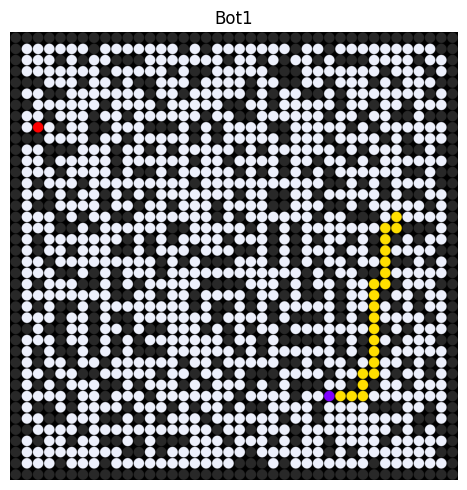

Fire started at position: (30, 35)

--- Time Step 1 ---
Bot moved to (16, 33)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# O O O O O O # O O O O O O O # O # O O O O O O O # O O # O O O O O O O O O # #
# O O O # O # O O # # # O O O O O O O # O O # O # O O # O # # # O O O O # O O #
# O O O O O O O # O O O O O # O # # O O O O O # # # O O O O O O O # O O O # O #
# # # O O O # O O # O # # O O O # O O O O # O O # # O O # O O O # O # O O O # #
# O O # # O O O O O O O # O O # O O O O O # O # O O # # O # O O O O O O O # O #
# # O O O O O O # O O O O # O O O O O # # O O # O O O O O # O O # O O # O O O #
# O O # O O O # O O # O O O O O O # O O # # O O O O O O # O O # O O # # O # # #
# O F O # O O # # O O O # # # O # O # O O O O # # O O O O O # O # O O O O O O #
# # # O O O O # O O # O O O O O # O # O O O O O # O O O # O O O O # O # O O O #
# O O # # # O O O # O O # O # O O O O O # O # O O O O O O # O # O O O # # O # #
# O O # O O O O O # O O O O O O # O O # O 

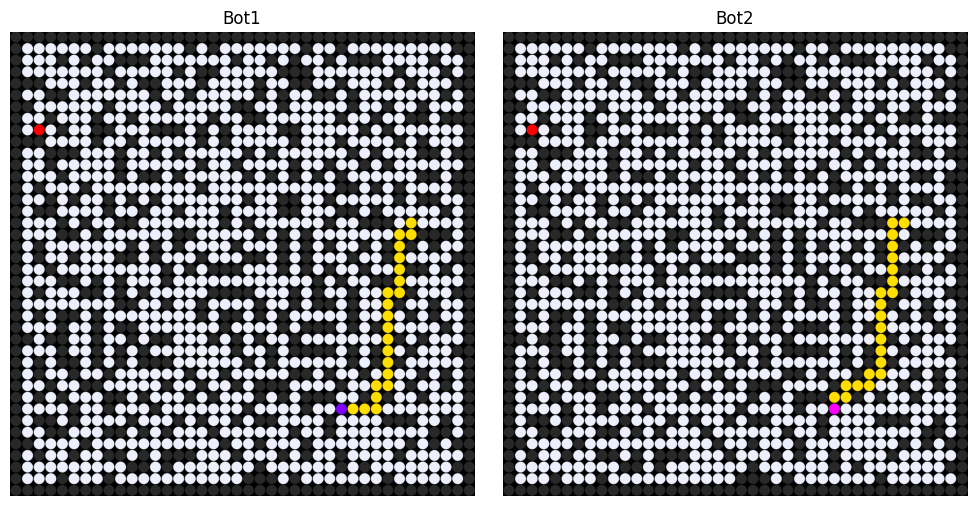

Fire started at position: (26, 18)

--- Time Step 1 ---
Bot moved to (16, 33)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# O O O O O O # O O O O O O O # O # O O O O O O O # O O # O O O O O O O O O # #
# O O O # O # O O # # # O O O O O O O # O O # O # O O # O # # # O O O O # O O #
# O O O O O O O # O O O O O # O # # O O O O O # # # O O O O O O O # O O O # O #
# # # O O O # O O # O # # O O O # O O O O # O O # # O O # O O O # O # O O O # #
# O O # # O O O O O O O # O O # O O O O O # O # O O # # O # O O O O O O O # O #
# # O O O O O O # O O O O # O O O O O # # O O # O O O O O # O O # O O # O O O #
# O O # O O O # O O # O O O O O O # O O # # O O O O O O # O O # O O # # O # # #
# O F O # O O # # O O O # # # O # O # O O O O # # O O O O O # O # O O O O O O #
# # # O O O O # O O # O O O O O # O # O O O O O # O O O # O O O O # O # O O O #
# O O # # # O O O # O O # O # O O O O O # O # O O O O O O # O # O O O # # O # #
# O O # O O O O O # O O O O O O # O O # O 

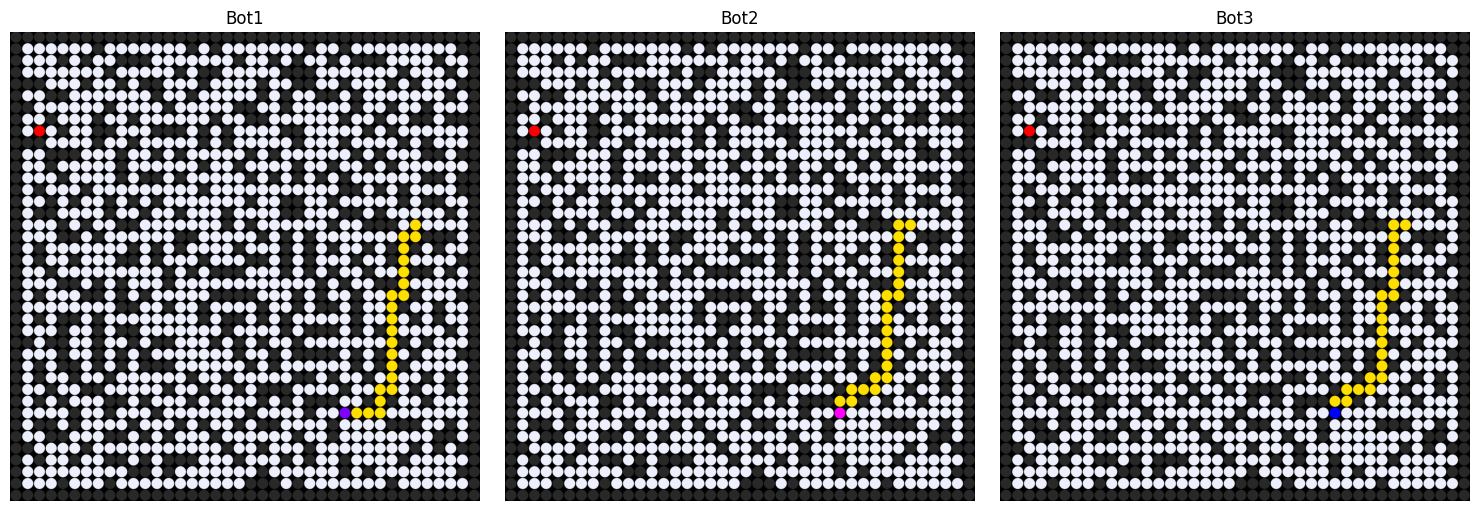

Fire started at position: (2, 25)
Bot moved to (16, 33) at step 1
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# O O O O O O # O O O O O O O # O # O O O O O O O # O O # O O O O O O O O O # #
# O O O # O # O O # # # O O O O O O O # O O # O # O O # O # # # O O O O # O O #
# O O O O O O O # O O O O O # O # # O O O O O # # # O O O O O O O # O O O # O #
# # # O O O # O O # O # # O O O # O O O O # O O # # O O # O O O # O # O O O # #
# O O # # O O O O O O O # O O # O O O O O # O # O O # # O # O O O O O O O # O #
# # O O O O O O # O O O O # O O O O O # # O O # O O O O O # O O # O O # O O O #
# O O # O O O # O O # O O O O O O # O O # # O O O O O O # O O # O O # # O # # #
# O F O # O O # # O O O # # # O # O # O O O O # # O O O O O # O # O O O O O O #
# # # O O O O # O O # O O O O O # O # O O O O O # O O O # O O O O # O # O O O #
# O O # # # O O O # O O # O # O O O O O # O # O O O O O O # O # O O O # # O # #
# O O # O O O O O # O O O O O O # O O # O O O O # O O 

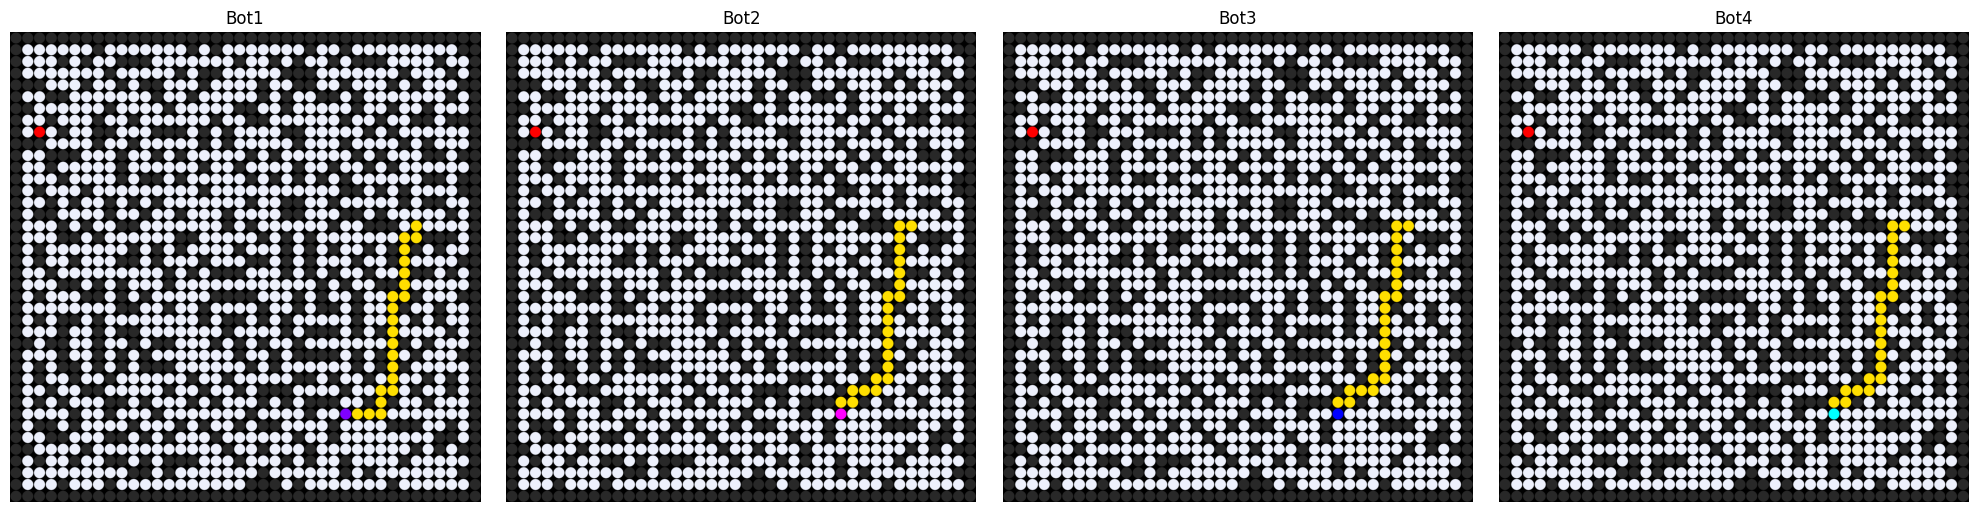

Running simulation 2 with q=0.00


KeyboardInterrupt: 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

goal_classes = [Bot1, Bot2, Bot3, Bot4]

goal_results, bot_results_df = run_simulation_for_bots(goal_classes, num_simulations=100, output_csv="Evaluation.csv")